In [1]:
from IPython.utils import io
import torch
import PIL
import imageio
import pickle
import os
import numpy as np
import random
import ipywidgets as widgets
import matplotlib.pyplot as plt
from PIL import Image
from models import get_instrumented_model
from decomposition import get_or_compute
from config import Config
from skimage import img_as_ubyte
from ipywidgets import fixed

import glob
import cv2

Current path: /home/taki/ganspace/models/stylegan2/stylegan2-pytorch
StyleGAN2: Optimized CUDA op FusedLeakyReLU not available, using native PyTorch fallback.
StyleGAN2: Optimized CUDA op UpFirDn2d not available, using native PyTorch fallback.


### Load model

In [2]:
# Speed up computation
torch.autograd.set_grad_enabled(False)
torch.backends.cudnn.benchmark = True

# Specify model to use
config = Config(
  model='StyleGAN2',
  layer='style',
  output_class='egg',
  components=80,
  use_w=True,
  n=1_000_000,
  batch_size=10_000, # style layer quite small
)

# config = Config(
#   model='StyleGAN2',
#   layer='style',
#   output_class='ffhq',
#   components=80,
#   use_w=True,}
#   n=1_000_000,
#   batch_size=10_000, # style layer quite small
# )


inst = get_instrumented_model(config.model, config.output_class,
                              config.layer, torch.device('cuda'), use_w=config.use_w)

path_to_components = get_or_compute(config, inst)

model = inst.model
with open(str(os.path.split(path_to_components)[0]) + '/pca_model.pkl', mode='rb') as f:
    transformer = pickle.load(f)

named_directions = {} #init named_directions dict to save directions

size 256
log_size: 8
num_layers: 13
n_latent: 14


## Multiple components
### Load components

In [3]:
comps = np.load(path_to_components)
lst = comps.files
latent_dirs = []
latent_stdevs = []
comp_dir = []
comp_dir_stdev = []

load_activations = True

for item in lst:
    if load_activations:
      if item == 'act_comp':
        for i in range(comps[item].shape[0]):
          latent_dirs.append(comps[item][i])
      if item == 'act_stdev':
        for i in range(comps[item].shape[0]):
          latent_stdevs.append(comps[item][i])
      if item == 'act_mean':
        comp_mean = comps[item]
    else:
      if item == 'lat_comp':
        for i in range(comps[item].shape[0]):
          latent_dirs.append(comps[item][i])
      if item == 'lat_stdev':
        for i in range(comps[item].shape[0]):
          latent_stdevs.append(comps[item][i])

num = 8

for i in range(num):
    comp_dir.append(latent_dirs[i])
    comp_dir_stdev.append(latent_stdevs[i])
    
print(f'Loaded Component No. 1~{num}')

Loaded Component No. 1~8


In [143]:
w = comp_mean
out = model.sample_np(w)
print(out.shape)
print(out)

(256, 256, 3)
[[[0.77059984 0.769814   0.7896068 ]
  [0.8032223  0.7821425  0.79774296]
  [0.7985864  0.7946165  0.8200444 ]
  ...
  [0.8032925  0.7995086  0.8276143 ]
  [0.7911197  0.78422284 0.8152001 ]
  [0.7548408  0.7435603  0.7622869 ]]

 [[0.7938024  0.78339815 0.81390154]
  [0.7963757  0.7881032  0.8196667 ]
  [0.79404104 0.78991556 0.8131379 ]
  ...
  [0.79432935 0.79312676 0.8296536 ]
  [0.79822266 0.794792   0.8318151 ]
  [0.7857394  0.7810619  0.8159923 ]]

 [[0.7961856  0.79731417 0.8345746 ]
  [0.7941227  0.7869829  0.8083284 ]
  [0.78907895 0.7857557  0.8108317 ]
  ...
  [0.79712    0.79264283 0.82254505]
  [0.7985395  0.7934187  0.82373166]
  [0.79610693 0.7939607  0.8234223 ]]

 ...

 [[0.8255781  0.8202113  0.85540897]
  [0.8294301  0.8283774  0.8720763 ]
  [0.8198854  0.8137373  0.84841233]
  ...
  [0.8130169  0.8117318  0.83507633]
  [0.81742775 0.81845677 0.8455144 ]
  [0.81477356 0.81768274 0.8528855 ]]

 [[0.82026577 0.81778467 0.85747737]
  [0.82770264 0.8216212

In [99]:
w.shape

(1, 512)

### Run UI

In [6]:
def display_sample_pytorch(seed, truncation, dir0, dir1, dir2, dir3, dir4, dir5, dir6, dir7, dim0, dim1, dim2, dim3, dim4, dim5, dim6, dim7, scale, start, end, disp=True, save=None, noise_spec=None):
    # blockPrint()
    # with io.capture_output() as captured:
    param = []
    inv = []
    
    #w = model.sample_latent(1, seed=seed).cpu().numpy()
    w = comp_mean

    #model.truncation = float(truncation) # これを入れると何故カエラーになるのか
    w = [w]*model.get_max_latents() # one per layer
    for l in range(start, end):
        w[l] =  w[l] + dir0 * dim0 * scale + dir1 * dim1 * scale + dir2 * dim2 * scale + dir3 * dim3 * scale + dir4 * dim4 * scale + dir5 * dim5 * scale + dir6 * dim6 * scale + dir7 * dim7 * scale
        param.append(transformer.transform(w[l]))
    
    # #print(param[0][0][:num])
    
    
    # #save image and display
    #w = torch.tensor(w)
    #w = np.array(w)
    #print(type(w))
    #print(w.shape)
    out = model.sample_np(w)
  
    final_im = Image.fromarray((out * 255).astype(np.uint8)).resize((256,256),Image.LANCZOS)

    if disp:
      display(final_im)

    if save is not None:
      if disp == False:
        print(save)
      final_im.save(f'out/{seed}_{save:05}.png')


#seed = np.random.randint(0,100000)
seed = np.random.randint(0,1000)
style = {'description_width': 'initial'}

#seed = widgets.IntSlider(min=0, max=100000, step=1, value=seed, description='Seed: ', continuous_update=False)
seed = widgets.IntSlider(min=0, max=1000, step=1, value=seed, description='Seed: ', continuous_update=False)
truncation = widgets.FloatSlider(min=0, max=2, step=0.1, value=0.7, description='Truncation: ', continuous_update=False)
dim0 = widgets.FloatSlider(min=-20, max=20, step=0.1, value=0, description='d1: ', continuous_update=False, style=style)
dim1 = widgets.FloatSlider(min=-20, max=20, step=0.1, value=0, description='d2: ', continuous_update=False, style=style)
dim2 = widgets.FloatSlider(min=-20, max=20, step=0.1, value=0, description='d3: ', continuous_update=False, style=style)
dim3 = widgets.FloatSlider(min=-20, max=20, step=0.1, value=0, description='d4: ', continuous_update=False, style=style)
dim4 = widgets.FloatSlider(min=-20, max=20, step=0.1, value=0, description='d5: ', continuous_update=False, style=style)
dim5 = widgets.FloatSlider(min=-20, max=20, step=1, value=0, description='d6: ', continuous_update=False, style=style)
dim6 = widgets.FloatSlider(min=-20, max=20, step=1, value=0, description='d7: ', continuous_update=False, style=style)
dim7 = widgets.FloatSlider(min=-20, max=20, step=1, value=0, description='d8: ', continuous_update=False, style=style)
scale = widgets.FloatSlider(min=0, max=20, step=0.5, value=1, description='Scale: ', continuous_update=False)
start_layer = widgets.IntSlider(min=0, max=model.get_max_latents(), step=1, value=0, description='start layer: ', continuous_update=False)
end_layer = widgets.IntSlider(min=0, max=model.get_max_latents(), step=1, value=18, description='end layer: ', continuous_update=False)

# Make sure layer range is valid
def update_range_start(*args):
  end_layer.min = start_layer.value
def update_range_end(*args):
  start_layer.max = end_layer.value
start_layer.observe(update_range_start, 'value')
end_layer.observe(update_range_end, 'value')

text = widgets.Text(description="Name component here", style=style, width=200)

bot_box = widgets.VBox([dim0, dim1, dim2, dim3, dim4, dim5, dim6, dim7, scale, start_layer, end_layer, seed, truncation])
ui = widgets.VBox([bot_box])

out = widgets.interactive_output(display_sample_pytorch, {'seed': seed, 'truncation': truncation, 'dir0': fixed(comp_dir[0]), 'dir1': fixed(comp_dir[1]), 'dir2': fixed(comp_dir[2]), 'dir3': fixed(comp_dir[3]), 'dir4': fixed(comp_dir[4]), 'dir5': fixed(comp_dir[5]), 'dir6': fixed(comp_dir[6]), 'dir7': fixed(comp_dir[7]), 'dim0': dim0, 'dim1': dim1, 'dim2': dim2, 'dim3': dim3, 'dim4': dim4, 'dim5': dim5, 'dim6': dim6, 'dim7': dim7, 'scale': scale, 'start': start_layer, 'end': end_layer})

display(out, ui)


Output()

In [10]:
w_read     = np.load('/home/taki/ganspace/gen_img_lat-mean-to-comp_-2to2sigma_batch64x4_310k-iter_fid=38-30437_compnum=5/w.npy')
w_read[0]

array([-1.92648292e-01,  9.19486046e-01,  4.71078962e-01,  9.36257303e-01,
       -1.15553066e-01,  2.36468196e+00,  1.03017676e+00, -2.54415900e-01,
        2.63393223e-01,  8.20031762e-02,  3.10337245e-01,  2.44150326e-01,
       -2.16255784e-01,  1.20603693e+00,  2.16840529e+00,  1.56191921e+00,
        2.36678690e-01, -1.37966707e-01, -5.52770436e-01, -1.38859302e-01,
        4.38093275e-01,  1.05584943e+00,  4.89420295e-01, -3.18389088e-02,
       -2.68664777e-01,  3.48962605e-01,  1.35984600e+00, -1.39991671e-01,
       -3.75008285e-01, -6.53413355e-01,  3.61702561e-01, -4.93155532e-02,
        8.05235863e-01, -1.21120453e-01, -3.03366005e-01,  9.18850750e-02,
        5.63033581e-01,  4.77517754e-01,  8.55784297e-01,  1.71695262e-01,
        1.24795556e+00,  4.42957580e-01,  1.41575778e+00, -6.36270866e-02,
        5.43826759e-01, -1.36158019e-02,  2.07395688e-01, -3.74851465e-01,
       -5.65483451e-01, -5.85994422e-02, -4.37052190e-01,  1.09414434e+00,
       -3.85404199e-01,  

### Save image

In [23]:
def display_sample_pytorch(seed, truncation, dir0, dir1, dir2, dir3, dir4, dir5, dir6, dir7, dim0, dim1, dim2, dim3, dim4, dim5, dim6, dim7, scale, start, end, save, disp=False,  noise_spec=None):
    # blockPrint()
    # with io.capture_output() as captured:
    param = []
    inv = []
    
    # w = model.sample_latent(1, seed=seed).cpu().numpy()
    w = comp_mean

    model.truncation = truncation
    w = [w]*model.get_max_latents() # one per layer
    
   
    for l in range(start, end):
        w[l] =  w[l] + dir0 * dim0 * scale + dir1 * dim1 * scale + dir2 * dim2 * scale + dir3 * dim3 * scale + dir4 * dim4 * scale + dir5 * dim5 * scale + dir6 * dim6 * scale + dir7 * dim7 * scale
        param.append(transformer.transform(w[l]))
    
#     print(param[0][0][:num])
    
    #save image and display
    out = model.sample_np(w)
    final_im = Image.fromarray((out * 255).astype(np.uint8)).resize((256,256),Image.LANCZOS)

    if disp:
      display(final_im)

    if save is not None:
      if disp == False:
        print(save)
      final_im.save(f'out/StyleGAN2-grain-final/GUI/dir_mean/comp7/comp7_{save}.png')


seed = 0
style = {'description_width': 'initial'}

truncation = 0.7
dim0 = 0
dim1 = 0
dim2 = 0
dim3 = 0
dim4 = 0
dim5 = 0
dim6 = 0
dim7 = 0
scale = 1
start_layer = 0
end_layer = 14

# Make sure layer range is valid
def update_range_start(*args):
  end_layer.min = start_layer.value
def update_range_end(*args):
  start_layer.max = end_layer.value
# start_layer.observe(update_range_start, 'value')
# end_layer.observe(update_range_end, 'value')

# text = widgets.Text(description="Name component here", style=style, width=200)

# bot_box = widgets.VBox([dim0, dim1, dim2, dim3, dim4, dim5, dim6, dim7, scale, start_layer, end_layer, seed])
# ui = widgets.VBox([bot_box])

# for i in range(-9, 10, 1):
#     dim7 = i
#     save = i
#     display_sample_pytorch(seed,  truncation, comp_dir[0], comp_dir[1], comp_dir[2], comp_dir[3], comp_dir[4], comp_dir[5], comp_dir[6], comp_dir[7], dim0, dim1, dim2, dim3, dim4, dim5, dim6, dim7, scale, start_layer, end_layer, save)

    
i = 50
dim6 = i
save = i
display_sample_pytorch(seed,  truncation, comp_dir[0], comp_dir[1], comp_dir[2], comp_dir[3], comp_dir[4], comp_dir[5], comp_dir[6], comp_dir[7], dim0, dim1, dim2, dim3, dim4, dim5, dim6, dim7, scale, start_layer, end_layer, save)

# display(out, ui)

50


In [131]:
dir_path = 'out/StyleGAN2-grain-final/GUI/dir/comp8'
paths = glob.glob(os.path.join(dir_path, '*.png'))
paths.sort()
print(paths)

['out/StyleGAN2-grain-final/GUI/dir/comp8/comp8_-1.png', 'out/StyleGAN2-grain-final/GUI/dir/comp8/comp8_-2.png', 'out/StyleGAN2-grain-final/GUI/dir/comp8/comp8_-3.png', 'out/StyleGAN2-grain-final/GUI/dir/comp8/comp8_-4.png', 'out/StyleGAN2-grain-final/GUI/dir/comp8/comp8_-5.png', 'out/StyleGAN2-grain-final/GUI/dir/comp8/comp8_-6.png', 'out/StyleGAN2-grain-final/GUI/dir/comp8/comp8_-7.png', 'out/StyleGAN2-grain-final/GUI/dir/comp8/comp8_-8.png', 'out/StyleGAN2-grain-final/GUI/dir/comp8/comp8_-9.png', 'out/StyleGAN2-grain-final/GUI/dir/comp8/comp8_0.png', 'out/StyleGAN2-grain-final/GUI/dir/comp8/comp8_1.png', 'out/StyleGAN2-grain-final/GUI/dir/comp8/comp8_2.png', 'out/StyleGAN2-grain-final/GUI/dir/comp8/comp8_3.png', 'out/StyleGAN2-grain-final/GUI/dir/comp8/comp8_4.png', 'out/StyleGAN2-grain-final/GUI/dir/comp8/comp8_5.png', 'out/StyleGAN2-grain-final/GUI/dir/comp8/comp8_6.png', 'out/StyleGAN2-grain-final/GUI/dir/comp8/comp8_7.png', 'out/StyleGAN2-grain-final/GUI/dir/comp8/comp8_8.png', 

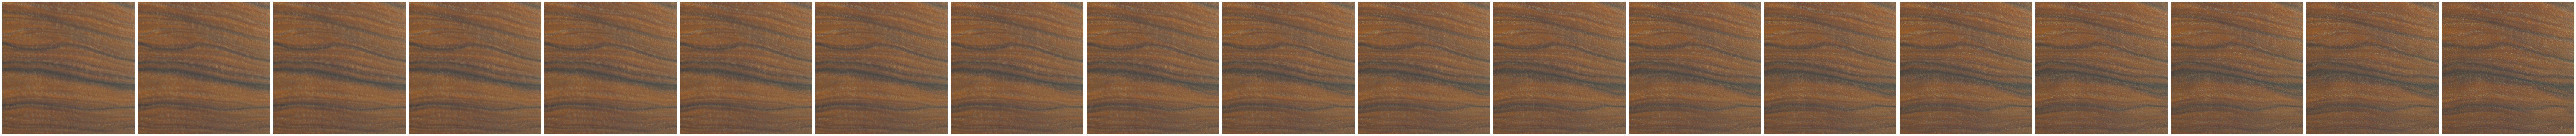

In [132]:
index = [8,7,6,5,4,3,2,1,0,9,10,11,12,13,14,15,16,17,18]
imgs = []
for i in range(len(paths)):
    img = cv2.imread(paths[index[i]])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    imgs.append(img)
    
fig, axs = plt.subplots(1, 19, figsize=(120,10), tight_layout='True')

for img, ax in zip(imgs, axs.flatten()):
    ax.imshow(img)
    ax.axis('off')

plt.savefig('out/StyleGAN2-grain-final/GUI/dir/comp8/comp8_summary.png')
plt.show()

### Run UI with transformer

In [53]:
def display_sample_pytorch(seed, truncation, dir0, dir1, dir2, dir3, dir4, dir5, dim0, dim1, dim2, dim3, dim4, dim5, scale, start, end, disp=True, save=None, noise_spec=None):
    # blockPrint()
    # with io.capture_output() as captured:
    param = []
    inv = []
    
    w = model.sample_latent(1, seed=seed).cpu().numpy()

    model.truncation = truncation
    w = [w]*model.get_max_latents() # one per layer
    for l in range(start, end):
        w[l] = w[l] + dir0 * dim0 * scale + dir1 * dim1 * scale + dir2 * dim2 * scale + dir3 * dim3 * scale + dir4 * dim4 * scale + dir5 * dim5 * scale
        # param.append(transformer.transform(w[l]))
        param.append(np.random.rand(1,6))
        inv.append(transformer.inverse_transform(param[l]))
        w[l][0] = inv[l][0].astype(np.float32)
        
    print(param[0][0][:num])

    #save image and display
    out = model.sample_np(w)
    final_im = Image.fromarray((out * 255).astype(np.uint8)).resize((256,256),Image.LANCZOS)

    if disp:
      display(final_im)

    if save is not None:
      if disp == False:
        print(save)
      final_im.save(f'out/{seed}_{save:05}.png')


seed = np.random.randint(0,100000)
style = {'description_width': 'initial'}

seed = widgets.IntSlider(min=0, max=100000, step=1, value=seed, description='Seed: ', continuous_update=False)
truncation = widgets.FloatSlider(min=0, max=2, step=0.1, value=0.7, description='Truncation: ', continuous_update=False)
dim0 = widgets.FloatSlider(min=-10, max=10, step=0.1, value=0, description='Comp1: ', continuous_update=False, style=style)
dim1 = widgets.FloatSlider(min=-10, max=10, step=0.1, value=0, description='Comp2: ', continuous_update=False, style=style)
dim2 = widgets.FloatSlider(min=-10, max=10, step=0.1, value=0, description='Comp3: ', continuous_update=False, style=style)
dim3 = widgets.FloatSlider(min=-10, max=10, step=0.1, value=0, description='Comp4: ', continuous_update=False, style=style)
dim4 = widgets.FloatSlider(min=-10, max=10, step=0.1, value=0, description='Comp5: ', continuous_update=False, style=style)
dim5 = widgets.FloatSlider(min=-10, max=10, step=0.1, value=0, description='Comp6: ', continuous_update=False, style=style)
scale = widgets.FloatSlider(min=0, max=10, step=0.05, value=1, description='Scale: ', continuous_update=False)
start_layer = widgets.IntSlider(min=0, max=model.get_max_latents(), step=1, value=0, description='start layer: ', continuous_update=False)
end_layer = widgets.IntSlider(min=0, max=model.get_max_latents(), step=1, value=18, description='end layer: ', continuous_update=False)

# Make sure layer range is valid
def update_range_start(*args):
  end_layer.min = start_layer.value
def update_range_end(*args):
  start_layer.max = end_layer.value
start_layer.observe(update_range_start, 'value')
end_layer.observe(update_range_end, 'value')

text = widgets.Text(description="Name component here", style=style, width=200)

bot_box = widgets.VBox([seed, dim0, dim1, dim2, dim3, dim4, dim5, scale, start_layer, end_layer])
ui = widgets.VBox([bot_box])

out = widgets.interactive_output(display_sample_pytorch, {'seed': seed, 'truncation': truncation, 'dir0': fixed(comp_dir[0]), 'dir1': fixed(comp_dir[1]), 'dir2': fixed(comp_dir[2]), 'dir3': fixed(comp_dir[3]), 'dir4': fixed(comp_dir[4]), 'dir5': fixed(comp_dir[5]), 'dim0': dim0, 'dim1': dim1, 'dim2': dim2, 'dim3': dim3, 'dim4': dim4, 'dim5': dim5, 'scale': scale, 'start': start_layer, 'end': end_layer})

display(out, ui)

Output()

## Single component
### Load a component

In [5]:
comps = np.load(path_to_components)
lst = comps.files
latent_dirs = []
latent_stdevs = []
comp_dir = []
comp_dir_stdev = []

load_activations = True

for item in lst:
    if load_activations:
      if item == 'act_comp':
        for i in range(comps[item].shape[0]):
          latent_dirs.append(comps[item][i])
      if item == 'act_stdev':
        for i in range(comps[item].shape[0]):
          latent_stdevs.append(comps[item][i])
    else:
      if item == 'lat_comp':
        for i in range(comps[item].shape[0]):
          latent_dirs.append(comps[item][i])
      if item == 'lat_stdev':
        for i in range(comps[item].shape[0]):
          latent_stdevs.append(comps[item][i])
            
#load one at random 
# num = np.random.randint(20)
# if num in named_directions.values():
#   print(f'Direction already named: {list(named_directions.keys())[list(named_directions.values()).index(num)]}')

num = 10

# comp_dir = latent_dirs[num]
# comp_dir_stdev = latent_stdevs[num]

comp_dir.append(latent_dirs[num])
comp_dir_stdev.append(latent_stdevs[num])
    
print(f'Loaded Component No. {num}')


Loaded Component No. 10


### Run UI

In [7]:
def display_sample_pytorch(seed, truncation, dir0, dim0, scale, start, end, disp=True, save=None, noise_spec=None):
    # blockPrint()
    # with io.capture_output() as captured:
    param = []
    w = model.sample_latent(1, seed=seed).cpu().numpy()

    model.truncation = truncation
    w = [w]*model.get_max_latents() # one per layer
    for l in range(start, end):
      w[l] = w[l] + dir0 * dim0 * scale 
      param.append(transformer.transform(w[l]))
        
#     print(param[0][0][num])

    #save image and display
    out = model.sample_np(w)
    final_im = Image.fromarray((out * 255).astype(np.uint8)).resize((256,256),Image.LANCZOS)

    if disp:
      display(final_im)
    if save is not None:
      if disp == False:
        print(save)
      final_im.save(f'out/{seed}_{save:05}.png')


seed = np.random.randint(0,100000)
style = {'description_width': 'initial'}

seed = widgets.IntSlider(min=0, max=100000, step=1, value=seed, description='Seed: ', continuous_update=False)
truncation = widgets.FloatSlider(min=0, max=2, step=0.1, value=0.7, description='Truncation: ', continuous_update=False)
dim0 = widgets.FloatSlider(min=-10, max=10, step=0.1, value=0, description='SelectedComp: ', continuous_update=False, style=style)
scale = widgets.FloatSlider(min=0, max=10, step=0.05, value=1, description='Scale: ', continuous_update=False)
start_layer = widgets.IntSlider(min=0, max=model.get_max_latents(), step=1, value=0, description='start layer: ', continuous_update=False)
end_layer = widgets.IntSlider(min=0, max=model.get_max_latents(), step=1, value=18, description='end layer: ', continuous_update=False)

# Make sure layer range is valid
def update_range_start(*args):
  end_layer.min = start_layer.value
def update_range_end(*args):
  start_layer.max = end_layer.value
start_layer.observe(update_range_start, 'value')
end_layer.observe(update_range_end, 'value')

text = widgets.Text(description="Name component here", style=style, width=200)

bot_box = widgets.VBox([seed, dim0, scale, start_layer, end_layer])
ui = widgets.VBox([bot_box])

out = widgets.interactive_output(display_sample_pytorch, {'seed': seed, 'truncation': truncation, 'dir0': fixed(comp_dir[0]), 'dim0': dim0, 'scale': scale, 'start': start_layer, 'end': end_layer})

display(out, ui)


Output()

# Convert w to param

In [5]:
w_test = np.load('questionnaire/w_test.npy')
print(w_test.shape)
print(w_test)
param_test = transformer.transform(w_test)
print(param_test.shape)
print(param_test)
np.save('questionnaire/param_test.npy', param_test)

(34, 512)
[[ 0.3440561  -0.950136    0.5900445  ... -0.62184376 -0.43264222
   1.2390425 ]
 [ 0.37139365 -0.6246364   0.80698174 ... -1.2422309  -1.9276294
  -0.23519118]
 [-0.09118952 -0.20676489  1.1669356  ... -0.7095085   1.6524553
   0.98981756]
 ...
 [ 0.79115605 -0.30226016 -0.20428316 ... -0.8007261   0.14960529
   0.93486595]
 [ 1.0991617  -0.961632    0.8275591  ...  0.46156552 -1.6141889
   0.42750245]
 [ 0.14710009 -1.0717025   0.20085426 ... -0.7783195   0.9358142
   0.01562361]]
